# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 6.3 MB 53.5 MB/s 
     |████████████████████████████████| 16.7 MB 49.4 MB/s 
     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 2.1 MB 5.0 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase1_all.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
ORA_poly = Polygon([(2.5, 6.1), (2.5, 3.7), (6.9, 3.7), (6.9, 6.1)])

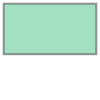

In [ ]:
ORA_poly

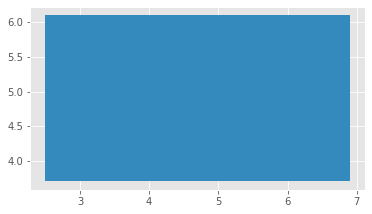

In [ ]:
 p = gpd.GeoSeries(ORA_poly)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
dftest['newfrom'] = lookup(dftest['from'], format='%d/%m/%Y, %H:%M:%S')
dftest['newto'] = lookup(dftest['to'], format='%d/%m/%Y, %H:%M:%S')

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient',
 'Location',
 'from',
 'to',
 'xlocation',
 'ylocation',
 'newfrom',
 'newto']

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframeusing the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
ORA_poly_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(ORA_poly))

In [ ]:
ORA_poly_gdf

,geometry
0,"POLYGON ((2.50000 6.10000, 2.50000 3.70000, 6...."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
AF_join = gpd.sjoin(gdf, ORA_poly_gdf, how = 'inner')
AF_join

,Patient,Location,from,to,xlocation,ylocation,newfrom,newto,geometry,index_right
17,G0132,"4.544,4.435","08/11/2021, 12:32:49","08/11/2021, 12:37:13",4.544,4.435,2021-11-08 12:32:49,2021-11-08 12:37:13,POINT (4.54400 4.43500),0
63,G0167,"6.857,4.27","11/11/2021, 13:31:07","11/11/2021, 13:34:06",6.857,4.27,2021-11-11 13:31:07,2021-11-11 13:34:06,POINT (6.85700 4.27000),0
64,G0167,"5.618,4.173","11/11/2021, 13:34:06","11/11/2021, 13:34:10",5.618,4.173,2021-11-11 13:34:06,2021-11-11 13:34:10,POINT (5.61800 4.17300),0
125,G0501,"3.668,4.51","11/10/2021, 10:46:43","11/10/2021, 10:46:47",3.668,4.51,2021-10-11 10:46:43,2021-10-11 10:46:47,POINT (3.66800 4.51000),0
126,G0501,"5.126,4.548","11/10/2021, 10:46:47","11/10/2021, 10:50:19",5.126,4.548,2021-10-11 10:46:47,2021-10-11 10:50:19,POINT (5.12600 4.54800),0
...,...,...,...,...,...,...,...,...,...,...
74220,R0823,"3.476,5.894","15/11/2021, 16:15:38","15/11/2021, 16:16:06",3.476,5.894,2021-11-15 16:15:38,2021-11-15 16:16:06,POINT (3.47600 5.89400),0
74946,R0840,"3.206,5.67","16/11/2021, 14:35:31","16/11/2021, 14:35:45",3.206,5.67,2021-11-16 14:35:31,2021-11-16 14:35:45,POINT (3.20600 5.67000),0
75954,R0858,"3.328,5.497","17/11/2021, 14:21:22","17/11/2021, 14:21:38",3.328,5.497,2021-11-17 14:21:22,2021-11-17 14:21:38,POINT (3.32800 5.49700),0
76566,R1089,"3.806,4.116","12/11/2021, 11:49:10","12/11/2021, 11:49:16",3.806,4.116,2021-11-12 11:49:10,2021-11-12 11:49:16,POINT (3.80600 4.11600),0


## More data cleaning

In [ ]:
discard = ['f', 'T']
AF_join = AF_join[~AF_join.Patient.str.contains(('|'.join(discard)))]
AF_join

,Patient,Location,from,to,xlocation,ylocation,newfrom,newto,geometry,index_right
17,G0132,"4.544,4.435","08/11/2021, 12:32:49","08/11/2021, 12:37:13",4.544,4.435,2021-11-08 12:32:49,2021-11-08 12:37:13,POINT (4.54400 4.43500),0
63,G0167,"6.857,4.27","11/11/2021, 13:31:07","11/11/2021, 13:34:06",6.857,4.27,2021-11-11 13:31:07,2021-11-11 13:34:06,POINT (6.85700 4.27000),0
64,G0167,"5.618,4.173","11/11/2021, 13:34:06","11/11/2021, 13:34:10",5.618,4.173,2021-11-11 13:34:06,2021-11-11 13:34:10,POINT (5.61800 4.17300),0
125,G0501,"3.668,4.51","11/10/2021, 10:46:43","11/10/2021, 10:46:47",3.668,4.51,2021-10-11 10:46:43,2021-10-11 10:46:47,POINT (3.66800 4.51000),0
126,G0501,"5.126,4.548","11/10/2021, 10:46:47","11/10/2021, 10:50:19",5.126,4.548,2021-10-11 10:46:47,2021-10-11 10:50:19,POINT (5.12600 4.54800),0
...,...,...,...,...,...,...,...,...,...,...
74220,R0823,"3.476,5.894","15/11/2021, 16:15:38","15/11/2021, 16:16:06",3.476,5.894,2021-11-15 16:15:38,2021-11-15 16:16:06,POINT (3.47600 5.89400),0
74946,R0840,"3.206,5.67","16/11/2021, 14:35:31","16/11/2021, 14:35:45",3.206,5.67,2021-11-16 14:35:31,2021-11-16 14:35:45,POINT (3.20600 5.67000),0
75954,R0858,"3.328,5.497","17/11/2021, 14:21:22","17/11/2021, 14:21:38",3.328,5.497,2021-11-17 14:21:22,2021-11-17 14:21:38,POINT (3.32800 5.49700),0
76566,R1089,"3.806,4.116","12/11/2021, 11:49:10","12/11/2021, 11:49:16",3.806,4.116,2021-11-12 11:49:10,2021-11-12 11:49:16,POINT (3.80600 4.11600),0


## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
dfgrouped = AF_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G0132,2021-11-08 12:32:49,2021-11-08 12:37:13
1,G0167,2021-11-11 13:31:07,2021-11-11 13:34:10
2,G0501,2021-10-11 10:46:43,2021-10-11 10:50:21
3,G0502,2021-10-11 10:57:29,2021-10-11 10:59:58
4,G0503,2021-10-11 11:24:46,2021-10-11 11:28:07
...,...,...,...
670,R0778,2021-11-11 10:50:39,2021-11-11 10:50:46
671,R0823,2021-11-15 16:10:22,2021-11-15 16:16:06
672,R0840,2021-11-16 14:35:31,2021-11-16 14:35:45
673,R0858,2021-11-17 14:21:22,2021-11-17 14:21:38


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 12:48:16')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G0132,2021-11-08 12:32:49,2021-11-08 12:37:13,0 days 00:04:24,8,8,equal
1,G0167,2021-11-11 13:31:07,2021-11-11 13:34:10,0 days 00:03:03,11,11,equal
2,G0501,2021-10-11 10:46:43,2021-10-11 10:50:21,0 days 00:03:38,11,11,equal
3,G0502,2021-10-11 10:57:29,2021-10-11 10:59:58,0 days 00:02:29,11,11,equal
4,G0503,2021-10-11 11:24:46,2021-10-11 11:28:07,0 days 00:03:21,11,11,equal
...,...,...,...,...,...,...,...
670,R0778,2021-11-11 10:50:39,2021-11-11 10:50:46,0 days 00:00:07,11,11,equal
671,R0823,2021-11-15 16:10:22,2021-11-15 16:16:06,0 days 00:05:44,15,15,equal
672,R0840,2021-11-16 14:35:31,2021-11-16 14:35:45,0 days 00:00:14,16,16,equal
673,R0858,2021-11-17 14:21:22,2021-11-17 14:21:38,0 days 00:00:16,17,17,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 12:48:16')

In [ ]:
dfgrouped['visit_length'].describe()

count                          675
mean     0 days 00:07:54.139259259
std      0 days 00:32:03.330951995
min                0 days 00:00:01
25%         0 days 00:03:05.500000
50%                0 days 00:04:34
75%         0 days 00:07:21.500000
max                0 days 12:48:16
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G0132,2021-11-08 12:32:49,2021-11-08 12:37:13,0 days 00:04:24,8,8,equal,Monday
1,G0167,2021-11-11 13:31:07,2021-11-11 13:34:10,0 days 00:03:03,11,11,equal,Thursday
2,G0501,2021-10-11 10:46:43,2021-10-11 10:50:21,0 days 00:03:38,11,11,equal,Monday
3,G0502,2021-10-11 10:57:29,2021-10-11 10:59:58,0 days 00:02:29,11,11,equal,Monday
4,G0503,2021-10-11 11:24:46,2021-10-11 11:28:07,0 days 00:03:21,11,11,equal,Monday
...,...,...,...,...,...,...,...,...
670,R0778,2021-11-11 10:50:39,2021-11-11 10:50:46,0 days 00:00:07,11,11,equal,Thursday
671,R0823,2021-11-15 16:10:22,2021-11-15 16:16:06,0 days 00:05:44,15,15,equal,Monday
672,R0840,2021-11-16 14:35:31,2021-11-16 14:35:45,0 days 00:00:14,16,16,equal,Tuesday
673,R0858,2021-11-17 14:21:22,2021-11-17 14:21:38,0 days 00:00:16,17,17,equal,Wednesday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G0132,2021-11-08 12:32:49,2021-11-08 12:37:13,0 days 00:04:24,8,8,equal,Monday
1,G0167,2021-11-11 13:31:07,2021-11-11 13:34:10,0 days 00:03:03,11,11,equal,Thursday
2,G0501,2021-10-11 10:46:43,2021-10-11 10:50:21,0 days 00:03:38,11,11,equal,Monday
3,G0502,2021-10-11 10:57:29,2021-10-11 10:59:58,0 days 00:02:29,11,11,equal,Monday
4,G0503,2021-10-11 11:24:46,2021-10-11 11:28:07,0 days 00:03:21,11,11,equal,Monday
...,...,...,...,...,...,...,...,...
670,R0778,2021-11-11 10:50:39,2021-11-11 10:50:46,0 days 00:00:07,11,11,equal,Thursday
671,R0823,2021-11-15 16:10:22,2021-11-15 16:16:06,0 days 00:05:44,15,15,equal,Monday
672,R0840,2021-11-16 14:35:31,2021-11-16 14:35:45,0 days 00:00:14,16,16,equal,Tuesday
673,R0858,2021-11-17 14:21:22,2021-11-17 14:21:38,0 days 00:00:16,17,17,equal,Wednesday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon   0 days 00:06:12.390151515
morning     0 days 00:08:59.496350364
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:06:19.650306748
Tuesday,0 days 00:06:16.637037037
Wednesday,0 days 00:06:20.294117647
Thursday,0 days 00:14:20.852941176
Friday,0 days 00:06:06.847619047
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
163
Tuesday
135
Wednesday
136
Thursday
136
Friday
105
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G0132,2021-11-08 12:32:49,2021-11-08 12:37:13,0 days 00:04:24,8,8,equal,Monday,morning,12
1,G0167,2021-11-11 13:31:07,2021-11-11 13:34:10,0 days 00:03:03,11,11,equal,Thursday,morning,13
2,G0501,2021-10-11 10:46:43,2021-10-11 10:50:21,0 days 00:03:38,11,11,equal,Monday,morning,10
3,G0502,2021-10-11 10:57:29,2021-10-11 10:59:58,0 days 00:02:29,11,11,equal,Monday,morning,10
4,G0503,2021-10-11 11:24:46,2021-10-11 11:28:07,0 days 00:03:21,11,11,equal,Monday,morning,11
...,...,...,...,...,...,...,...,...,...,...
670,R0778,2021-11-11 10:50:39,2021-11-11 10:50:46,0 days 00:00:07,11,11,equal,Thursday,morning,10
671,R0823,2021-11-15 16:10:22,2021-11-15 16:16:06,0 days 00:05:44,15,15,equal,Monday,afternoon,16
672,R0840,2021-11-16 14:35:31,2021-11-16 14:35:45,0 days 00:00:14,16,16,equal,Tuesday,afternoon,14
673,R0858,2021-11-17 14:21:22,2021-11-17 14:21:38,0 days 00:00:16,17,17,equal,Wednesday,afternoon,14


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
9              0 days 00:04:04
10   0 days 00:13:11.769784172
11   0 days 00:07:18.177304964
12   0 days 00:07:04.567567567
13   0 days 00:05:27.054545454
14   0 days 00:06:09.448717948
15   0 days 00:06:24.893617021
16   0 days 00:05:21.214285714
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
2
Ten
139
Eleven
141
Twelve
74
One
55
Two
156
Three
94
Four
14


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:08:01.022658610
R   0 days 00:02:03.615384615
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
662
Medical Retinal
13


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:32:49,2021-11-08 12:37:13,0 days 00:04:24,8,8,equal,Monday,morning,12,G,4.4000
1,G0167,2021-11-11 13:31:07,2021-11-11 13:34:10,0 days 00:03:03,11,11,equal,Thursday,morning,13,G,3.0500
2,G0501,2021-10-11 10:46:43,2021-10-11 10:50:21,0 days 00:03:38,11,11,equal,Monday,morning,10,G,3.6333
3,G0502,2021-10-11 10:57:29,2021-10-11 10:59:58,0 days 00:02:29,11,11,equal,Monday,morning,10,G,2.4833
4,G0503,2021-10-11 11:24:46,2021-10-11 11:28:07,0 days 00:03:21,11,11,equal,Monday,morning,11,G,3.3500
...,...,...,...,...,...,...,...,...,...,...,...,...
670,R0778,2021-11-11 10:50:39,2021-11-11 10:50:46,0 days 00:00:07,11,11,equal,Thursday,morning,10,R,0.1167
671,R0823,2021-11-15 16:10:22,2021-11-15 16:16:06,0 days 00:05:44,15,15,equal,Monday,afternoon,16,R,5.7333
672,R0840,2021-11-16 14:35:31,2021-11-16 14:35:45,0 days 00:00:14,16,16,equal,Tuesday,afternoon,14,R,0.2333
673,R0858,2021-11-17 14:21:22,2021-11-17 14:21:38,0 days 00:00:16,17,17,equal,Wednesday,afternoon,14,R,0.2667


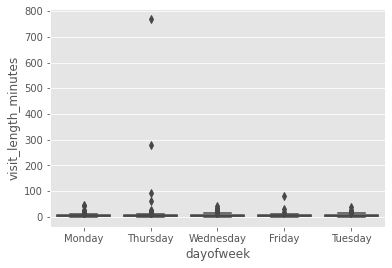

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

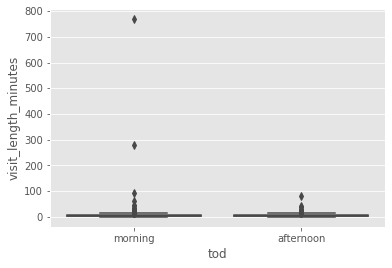

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

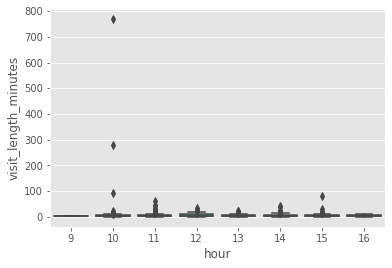

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

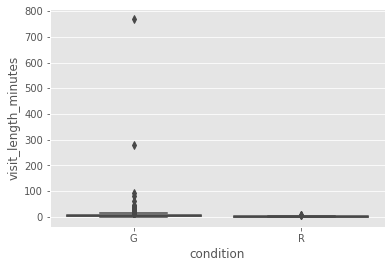

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 578
newfrom                 578
newto                   578
visit_length            578
start_day               578
end_day                 578
sameday                 578
dayofweek               578
tod                     578
hour                    578
condition               578
visit_length_minutes    578
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:32:49,2021-11-08 12:37:13,0 days 00:04:24,8,8,equal,Monday,morning,12,G,4.4000
1,G0167,2021-11-11 13:31:07,2021-11-11 13:34:10,0 days 00:03:03,11,11,equal,Thursday,morning,13,G,3.0500
2,G0501,2021-10-11 10:46:43,2021-10-11 10:50:21,0 days 00:03:38,11,11,equal,Monday,morning,10,G,3.6333
3,G0502,2021-10-11 10:57:29,2021-10-11 10:59:58,0 days 00:02:29,11,11,equal,Monday,morning,10,G,2.4833
4,G0503,2021-10-11 11:24:46,2021-10-11 11:28:07,0 days 00:03:21,11,11,equal,Monday,morning,11,G,3.3500
...,...,...,...,...,...,...,...,...,...,...,...,...
670,R0778,2021-11-11 10:50:39,2021-11-11 10:50:46,0 days 00:00:07,11,11,equal,Thursday,morning,10,R,0.1167
671,R0823,2021-11-15 16:10:22,2021-11-15 16:16:06,0 days 00:05:44,15,15,equal,Monday,afternoon,16,R,5.7333
672,R0840,2021-11-16 14:35:31,2021-11-16 14:35:45,0 days 00:00:14,16,16,equal,Tuesday,afternoon,14,R,0.2333
673,R0858,2021-11-17 14:21:22,2021-11-17 14:21:38,0 days 00:00:16,17,17,equal,Wednesday,afternoon,14,R,0.2667


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

6.3688707280832135
6.3688707280832135


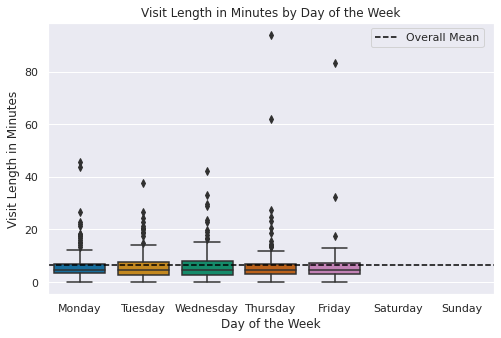

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

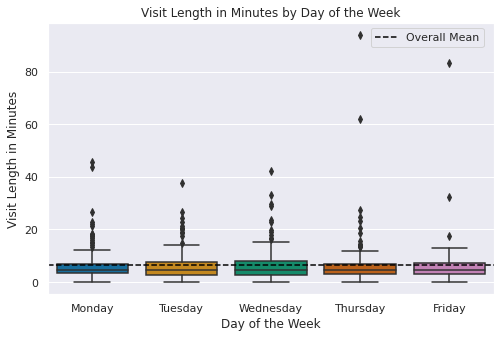

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

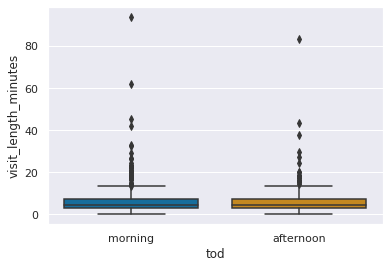

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

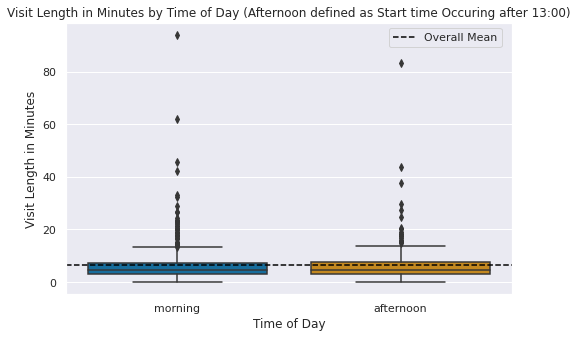

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

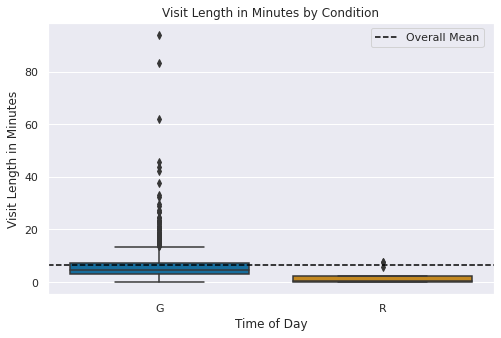

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

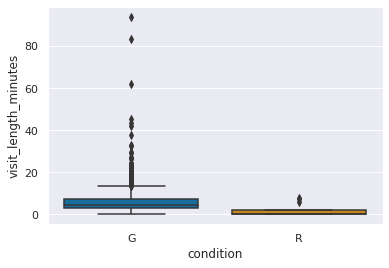

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

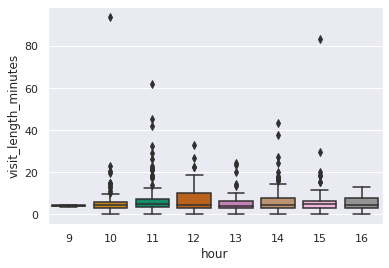

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

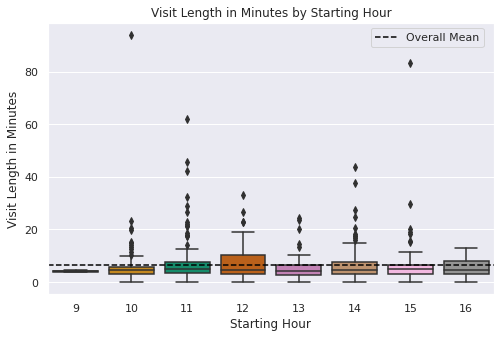

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   673.0000
mean                                      6.3689
std                                       7.6224
min                                       0.0167
25%                                       3.0833
50%                                       4.5333
75%                                       7.3167
max                                      93.9500
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   675.0000
mean                                      7.9023
std                                      32.0555
min                                       0.0167
25%                                       3.0917
50%                                       4.5667
75%                                       7.3583
max                                     768.2667
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

4.566666666666666

In [ ]:
df_outliers['visit_length'].describe()

count                          673
mean     0 days 00:06:22.132243684
std      0 days 00:07:37.344065330
min                0 days 00:00:01
25%                0 days 00:03:05
50%                0 days 00:04:32
75%                0 days 00:07:19
max                0 days 01:33:57
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          675
mean     0 days 00:07:54.139259259
std      0 days 00:32:03.330951995
min                0 days 00:00:01
25%         0 days 00:03:05.500000
50%                0 days 00:04:34
75%         0 days 00:07:21.500000
max                0 days 12:48:16
Name: visit_length, dtype: object

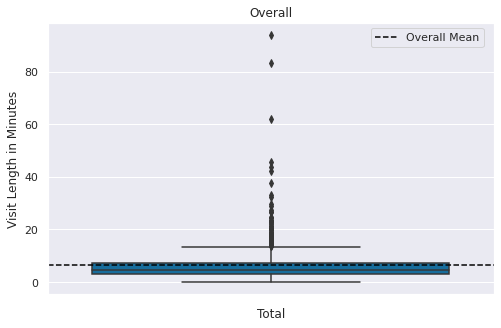

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
2
Ten
137
Eleven
141
Twelve
74
One
55
Two
156
Three
94
Four
14


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
163
Tuesday Outlier
135
Wednesday Outlier
136
Thursday Outlier
134
Friday Outlier
105
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                        6.3275
Tuesday                                       6.2773
Wednesday                                     6.3382
Thursday                                      6.7422
Friday                                        6.1141
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
660
R
13


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                     6.4537
R                                     2.0603
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
409
afternoon
264


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                     6.2065
morning                                       6.4737
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
2
Ten
137
Eleven
141
Twelve
74
One
55
Two
156
Three
94
Four
14


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
9                                      4.0667
10                                     5.7405
11                                     7.3030
12                                     7.0761
13                                     5.4509
14                                     6.1575
15                                     6.4149
16                                     5.3536
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 578
newfrom                 578
newto                   578
visit_length            578
start_day               578
end_day                 578
sameday                 578
dayofweek               578
tod                     578
hour                    578
condition               578
visit_length_minutes    578
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 0
newfrom                 0
newto                   0
visit_length            0
start_day               0
end_day                 0
sameday                 0
dayofweek               0
tod                     0
hour                    0
condition               0
visit_length_minutes    0
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 673
newfrom                 673
newto                   673
visit_length            673
start_day               673
end_day                 673
sameday                 673
dayofweek               673
tod                     673
hour                    673
condition               673
visit_length_minutes    673
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
309,G0827,2021-11-02 13:30:19,2021-11-02 13:30:20,0 days 00:00:01,2,2,equal,Tuesday,morning,13,G,0.0167
105,G0611,2021-10-20 14:46:26,2021-10-20 14:46:28,0 days 00:00:02,20,20,equal,Wednesday,afternoon,14,G,0.0333
113,G0619,2021-10-21 10:41:09,2021-10-21 10:41:11,0 days 00:00:02,21,21,equal,Thursday,morning,10,G,0.0333
127,G0634,2021-10-21 14:26:32,2021-10-21 14:26:34,0 days 00:00:02,21,21,equal,Thursday,afternoon,14,G,0.0333
137,G0645,2021-10-21 16:19:23,2021-10-21 16:19:25,0 days 00:00:02,21,21,equal,Thursday,afternoon,16,G,0.0333


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
309,G0827,2021-11-02 13:30:19,2021-11-02 13:30:20,0 days 00:00:01,2,2,equal,Tuesday,morning,13,G,0.0167
105,G0611,2021-10-20 14:46:26,2021-10-20 14:46:28,0 days 00:00:02,20,20,equal,Wednesday,afternoon,14,G,0.0333
113,G0619,2021-10-21 10:41:09,2021-10-21 10:41:11,0 days 00:00:02,21,21,equal,Thursday,morning,10,G,0.0333
127,G0634,2021-10-21 14:26:32,2021-10-21 14:26:34,0 days 00:00:02,21,21,equal,Thursday,afternoon,14,G,0.0333
137,G0645,2021-10-21 16:19:23,2021-10-21 16:19:25,0 days 00:00:02,21,21,equal,Thursday,afternoon,16,G,0.0333


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
10,G0510,2021-10-14 10:59:09,2021-10-14 12:33:06,0 days 01:33:57,14,14,equal,Thursday,morning,10,G,93.9500
266,G0781,2021-10-29 15:25:37,2021-10-29 16:48:51,0 days 01:23:14,29,29,equal,Friday,afternoon,15,G,83.2333
298,G0816,2021-10-28 11:52:26,2021-10-28 12:54:15,0 days 01:01:49,28,28,equal,Thursday,morning,11,G,61.8167
198,G0709,2021-10-25 11:56:36,2021-10-25 12:42:10,0 days 00:45:34,25,25,equal,Monday,morning,11,G,45.5667
583,G1137,2021-11-15 14:49:17,2021-11-15 15:32:50,0 days 00:43:33,15,15,equal,Monday,afternoon,14,G,43.5500


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
10,G0510,2021-10-14 10:59:09,2021-10-14 12:33:06,0 days 01:33:57,14,14,equal,Thursday,morning,10,G,93.9500
266,G0781,2021-10-29 15:25:37,2021-10-29 16:48:51,0 days 01:23:14,29,29,equal,Friday,afternoon,15,G,83.2333
298,G0816,2021-10-28 11:52:26,2021-10-28 12:54:15,0 days 01:01:49,28,28,equal,Thursday,morning,11,G,61.8167
198,G0709,2021-10-25 11:56:36,2021-10-25 12:42:10,0 days 00:45:34,25,25,equal,Monday,morning,11,G,45.5667
583,G1137,2021-11-15 14:49:17,2021-11-15 15:32:50,0 days 00:43:33,15,15,equal,Monday,afternoon,14,G,43.5500


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
661,G1221,2021-11-25 10:11:47,2021-11-25 23:00:03,0 days 12:48:16,25,25,equal,Thursday,morning,10,G,768.2667
295,G0813,2021-10-28 10:41:40,2021-10-28 15:21:13,0 days 04:39:33,28,28,equal,Thursday,morning,10,G,279.5500
10,G0510,2021-10-14 10:59:09,2021-10-14 12:33:06,0 days 01:33:57,14,14,equal,Thursday,morning,10,G,93.9500
266,G0781,2021-10-29 15:25:37,2021-10-29 16:48:51,0 days 01:23:14,29,29,equal,Friday,afternoon,15,G,83.2333
298,G0816,2021-10-28 11:52:26,2021-10-28 12:54:15,0 days 01:01:49,28,28,equal,Thursday,morning,11,G,61.8167
198,G0709,2021-10-25 11:56:36,2021-10-25 12:42:10,0 days 00:45:34,25,25,equal,Monday,morning,11,G,45.5667
583,G1137,2021-11-15 14:49:17,2021-11-15 15:32:50,0 days 00:43:33,15,15,equal,Monday,afternoon,14,G,43.5500
180,G0689,2021-10-27 11:13:52,2021-10-27 11:55:58,0 days 00:42:06,27,27,equal,Wednesday,morning,11,G,42.1000
99,G0604,2021-10-19 14:16:13,2021-10-19 14:53:46,0 days 00:37:33,19,19,equal,Tuesday,afternoon,14,G,37.5500
210,G0721,2021-10-27 12:11:51,2021-10-27 12:44:53,0 days 00:33:02,27,27,equal,Wednesday,morning,12,G,33.0333


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
10,G0510,2021-10-14 10:59:09,2021-10-14 12:33:06,0 days 01:33:57,14,14,equal,Thursday,morning,10,G,93.9500
266,G0781,2021-10-29 15:25:37,2021-10-29 16:48:51,0 days 01:23:14,29,29,equal,Friday,afternoon,15,G,83.2333
298,G0816,2021-10-28 11:52:26,2021-10-28 12:54:15,0 days 01:01:49,28,28,equal,Thursday,morning,11,G,61.8167
198,G0709,2021-10-25 11:56:36,2021-10-25 12:42:10,0 days 00:45:34,25,25,equal,Monday,morning,11,G,45.5667
583,G1137,2021-11-15 14:49:17,2021-11-15 15:32:50,0 days 00:43:33,15,15,equal,Monday,afternoon,14,G,43.5500
180,G0689,2021-10-27 11:13:52,2021-10-27 11:55:58,0 days 00:42:06,27,27,equal,Wednesday,morning,11,G,42.1000
99,G0604,2021-10-19 14:16:13,2021-10-19 14:53:46,0 days 00:37:33,19,19,equal,Tuesday,afternoon,14,G,37.5500
210,G0721,2021-10-27 12:11:51,2021-10-27 12:44:53,0 days 00:33:02,27,27,equal,Wednesday,morning,12,G,33.0333
33,G0536,2021-10-15 11:33:24,2021-10-15 12:05:51,0 days 00:32:27,15,15,equal,Friday,morning,11,G,32.4500
329,G0851,2021-11-03 15:32:09,2021-11-03 16:01:48,0 days 00:29:39,3,3,equal,Wednesday,afternoon,15,G,29.6500


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:32:49,2021-11-08 12:37:13,0 days 00:04:24,8,8,equal,Monday,morning,12,G,4.4000
1,G0167,2021-11-11 13:31:07,2021-11-11 13:34:10,0 days 00:03:03,11,11,equal,Thursday,morning,13,G,3.0500
2,G0501,2021-10-11 10:46:43,2021-10-11 10:50:21,0 days 00:03:38,11,11,equal,Monday,morning,10,G,3.6333
3,G0502,2021-10-11 10:57:29,2021-10-11 10:59:58,0 days 00:02:29,11,11,equal,Monday,morning,10,G,2.4833
4,G0503,2021-10-11 11:24:46,2021-10-11 11:28:07,0 days 00:03:21,11,11,equal,Monday,morning,11,G,3.3500
...,...,...,...,...,...,...,...,...,...,...,...,...
670,R0778,2021-11-11 10:50:39,2021-11-11 10:50:46,0 days 00:00:07,11,11,equal,Thursday,morning,10,R,0.1167
671,R0823,2021-11-15 16:10:22,2021-11-15 16:16:06,0 days 00:05:44,15,15,equal,Monday,afternoon,16,R,5.7333
672,R0840,2021-11-16 14:35:31,2021-11-16 14:35:45,0 days 00:00:14,16,16,equal,Tuesday,afternoon,14,R,0.2333
673,R0858,2021-11-17 14:21:22,2021-11-17 14:21:38,0 days 00:00:16,17,17,equal,Wednesday,afternoon,14,R,0.2667


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'AF'
ORAdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
ORAdf.to_csv('AFdf_phase1.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
